# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 50, 50, 50, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 50, 50, 50, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.9005
Epoch 1/200, Iteration 2/12, Loss: 0.6203
Epoch 1/200, Iteration 3/12, Loss: 0.3991
Epoch 1/200, Iteration 4/12, Loss: 0.2538
Epoch 1/200, Iteration 5/12, Loss: 0.3366
Epoch 1/200, Iteration 6/12, Loss: 0.3549
Epoch 1/200, Iteration 7/12, Loss: 0.3703
Epoch 1/200, Iteration 8/12, Loss: 0.3203
Epoch 1/200, Iteration 9/12, Loss: 0.3140
Epoch 1/200, Iteration 10/12, Loss: 0.2811
Epoch 1/200, Iteration 11/12, Loss: 0.3055
Epoch 1/200, Iteration 12/12, Loss: 0.2528
Epoch 1/200, Iteration 13/12, Loss: 0.2814
Train Error: 
 Accuracy: 63.88%, Avg loss: 0.258266, MRE: 0.259220, MAE: 0.034385 

Test Error: 
 Accuracy: 70.0%, Avg loss: 0.253497, MRE: 0.178224, MAE: 0.034848 

Epoch 2/200, Iteration 1/12, Loss: 0.2601
Epoch 2/200, Iteration 2/12, Loss: 0.2545
Epoch 2/200, Iteration 3/12, Loss: 0.2441
Epoch 2/200, Iteration 4/12, Loss: 0.2568
Epoch 2/200, Iteration 5/12, Loss: 0.2487
Epoch 2/200, Iteration 6/12, Loss: 0.2613
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 68.75%, Avg loss: 0.088024, MRE: 0.061774, MAE: 0.011250 

Test Error: 
 Accuracy: 61.5%, Avg loss: 0.093301, MRE: 0.060007, MAE: 0.011832 

Epoch 13/200, Iteration 1/12, Loss: 0.0953
Epoch 13/200, Iteration 2/12, Loss: 0.0715
Epoch 13/200, Iteration 3/12, Loss: 0.0868
Epoch 13/200, Iteration 4/12, Loss: 0.0843
Epoch 13/200, Iteration 5/12, Loss: 0.1047
Epoch 13/200, Iteration 6/12, Loss: 0.0744
Epoch 13/200, Iteration 7/12, Loss: 0.0497
Epoch 13/200, Iteration 8/12, Loss: 0.0855
Epoch 13/200, Iteration 9/12, Loss: 0.0792
Epoch 13/200, Iteration 10/12, Loss: 0.0664
Epoch 13/200, Iteration 11/12, Loss: 0.0732
Epoch 13/200, Iteration 12/12, Loss: 0.0550
Epoch 13/200, Iteration 13/12, Loss: 0.0638
Train Error: 
 Accuracy: 89.0%, Avg loss: 0.077321, MRE: 0.064084, MAE: 0.009631 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.064983, MRE: 0.042962, MAE: 0.007880 

Epoch 14/200, Iteration 1/12, Loss: 0.0777
Epoch 14/200, Iteration 2/12, Loss: 0.0686
Epoch 14/200, Iterat

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.050460, MRE: 0.036040, MAE: 0.006832 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.045614, MRE: 0.028344, MAE: 0.005961 

Epoch 25/200, Iteration 1/12, Loss: 0.0503
Epoch 25/200, Iteration 2/12, Loss: 0.0488
Epoch 25/200, Iteration 3/12, Loss: 0.0506
Epoch 25/200, Iteration 4/12, Loss: 0.0486
Epoch 25/200, Iteration 5/12, Loss: 0.0598
Epoch 25/200, Iteration 6/12, Loss: 0.0480
Epoch 25/200, Iteration 7/12, Loss: 0.0359
Epoch 25/200, Iteration 8/12, Loss: 0.0755
Epoch 25/200, Iteration 9/12, Loss: 0.0801
Epoch 25/200, Iteration 10/12, Loss: 0.0593
Epoch 25/200, Iteration 11/12, Loss: 0.0449
Epoch 25/200, Iteration 12/12, Loss: 0.0560
Epoch 25/200, Iteration 13/12, Loss: 0.0537
Train Error: 
 Accuracy: 84.75%, Avg loss: 0.058673, MRE: 0.041738, MAE: 0.007760 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.057731, MRE: 0.037129, MAE: 0.007548 

Epoch 26/200, Iteration 1/12, Loss: 0.0590
Epoch 26/200, Iteration 2/12, Loss: 0.0540
Epoch 26/200, Itera

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.017361, MRE: 0.019266, MAE: 0.002156 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016453, MRE: 0.013811, MAE: 0.002021 

Epoch 37/200, Iteration 1/12, Loss: 0.0187
Epoch 37/200, Iteration 2/12, Loss: 0.0180
Epoch 37/200, Iteration 3/12, Loss: 0.0227
Epoch 37/200, Iteration 4/12, Loss: 0.0147
Epoch 37/200, Iteration 5/12, Loss: 0.0120
Epoch 37/200, Iteration 6/12, Loss: 0.0208
Epoch 37/200, Iteration 7/12, Loss: 0.0291
Epoch 37/200, Iteration 8/12, Loss: 0.0188
Epoch 37/200, Iteration 9/12, Loss: 0.0169
Epoch 37/200, Iteration 10/12, Loss: 0.0169
Epoch 37/200, Iteration 11/12, Loss: 0.0145
Epoch 37/200, Iteration 12/12, Loss: 0.0138
Epoch 37/200, Iteration 13/12, Loss: 0.0178
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.017449, MRE: 0.018838, MAE: 0.002148 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016977, MRE: 0.013923, MAE: 0.002083 

Epoch 38/200, Iteration 1/12, Loss: 0.0151
Epoch 38/200, Iteration 2/12, Loss: 0.0158
Epoch 38/200, Itera

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.016494, MRE: 0.017198, MAE: 0.002042 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014750, MRE: 0.012385, MAE: 0.001830 

Epoch 49/200, Iteration 1/12, Loss: 0.0197
Epoch 49/200, Iteration 2/12, Loss: 0.0167
Epoch 49/200, Iteration 3/12, Loss: 0.0118
Epoch 49/200, Iteration 4/12, Loss: 0.0205
Epoch 49/200, Iteration 5/12, Loss: 0.0128
Epoch 49/200, Iteration 6/12, Loss: 0.0164
Epoch 49/200, Iteration 7/12, Loss: 0.0142
Epoch 49/200, Iteration 8/12, Loss: 0.0129
Epoch 49/200, Iteration 9/12, Loss: 0.0112
Epoch 49/200, Iteration 10/12, Loss: 0.0202
Epoch 49/200, Iteration 11/12, Loss: 0.0159
Epoch 49/200, Iteration 12/12, Loss: 0.0148
Epoch 49/200, Iteration 13/12, Loss: 0.0115
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.016190, MRE: 0.017212, MAE: 0.002012 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013272, MRE: 0.010849, MAE: 0.001614 

Epoch 50/200, Iteration 1/12, Loss: 0.0188
Epoch 50/200, Iteration 2/12, Loss: 0.0169
Epoch 50/200, Iterat

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.012167, MRE: 0.009965, MAE: 0.001538 

Epoch 61/200, Iteration 1/12, Loss: 0.0134
Epoch 61/200, Iteration 2/12, Loss: 0.0120
Epoch 61/200, Iteration 3/12, Loss: 0.0111
Epoch 61/200, Iteration 4/12, Loss: 0.0128
Epoch 61/200, Iteration 5/12, Loss: 0.0141
Epoch 61/200, Iteration 6/12, Loss: 0.0141
Epoch 61/200, Iteration 7/12, Loss: 0.0153
Epoch 61/200, Iteration 8/12, Loss: 0.0178
Epoch 61/200, Iteration 9/12, Loss: 0.0186
Epoch 61/200, Iteration 10/12, Loss: 0.0232
Epoch 61/200, Iteration 11/12, Loss: 0.0099
Epoch 61/200, Iteration 12/12, Loss: 0.0141
Epoch 61/200, Iteration 13/12, Loss: 0.0164
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.014756, MRE: 0.014941, MAE: 0.001837 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.012470, MRE: 0.010264, MAE: 0.001542 

Epoch 62/200, Iteration 1/12, Loss: 0.0150
Epoch 62/200, Iteration 2/12, Loss: 0.0188
Epoch 62/200, Iteration 3/12, Loss: 0.0146
Epoch 62/200, Iteration 4/12, Loss: 0.0167
Epoch 62/200, Ite

Epoch 72/200, Iteration 13/12, Loss: 0.0119
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.011741, MRE: 0.012113, MAE: 0.001474 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010501, MRE: 0.008650, MAE: 0.001316 

Epoch 73/200, Iteration 1/12, Loss: 0.0155
Epoch 73/200, Iteration 2/12, Loss: 0.0125
Epoch 73/200, Iteration 3/12, Loss: 0.0133
Epoch 73/200, Iteration 4/12, Loss: 0.0121
Epoch 73/200, Iteration 5/12, Loss: 0.0102
Epoch 73/200, Iteration 6/12, Loss: 0.0117
Epoch 73/200, Iteration 7/12, Loss: 0.0111
Epoch 73/200, Iteration 8/12, Loss: 0.0141
Epoch 73/200, Iteration 9/12, Loss: 0.0111
Epoch 73/200, Iteration 10/12, Loss: 0.0116
Epoch 73/200, Iteration 11/12, Loss: 0.0108
Epoch 73/200, Iteration 12/12, Loss: 0.0150
Epoch 73/200, Iteration 13/12, Loss: 0.0150
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.012079, MRE: 0.012456, MAE: 0.001497 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010645, MRE: 0.008750, MAE: 0.001332 

Epoch 74/200, Iteration 1/12, Loss: 0.0138
Epoch 74/200, Iter

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.017928, MRE: 0.016205, MAE: 0.002164 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016050, MRE: 0.011529, MAE: 0.001965 

Epoch 85/200, Iteration 1/12, Loss: 0.0186
Epoch 85/200, Iteration 2/12, Loss: 0.0216
Epoch 85/200, Iteration 3/12, Loss: 0.0096
Epoch 85/200, Iteration 4/12, Loss: 0.0135
Epoch 85/200, Iteration 5/12, Loss: 0.0197
Epoch 85/200, Iteration 6/12, Loss: 0.0139
Epoch 85/200, Iteration 7/12, Loss: 0.0102
Epoch 85/200, Iteration 8/12, Loss: 0.0134
Epoch 85/200, Iteration 9/12, Loss: 0.0115
Epoch 85/200, Iteration 10/12, Loss: 0.0148
Epoch 85/200, Iteration 11/12, Loss: 0.0134
Epoch 85/200, Iteration 12/12, Loss: 0.0101
Epoch 85/200, Iteration 13/12, Loss: 0.0135
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.013714, MRE: 0.013172, MAE: 0.001700 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.012228, MRE: 0.010291, MAE: 0.001539 

Epoch 86/200, Iteration 1/12, Loss: 0.0115
Epoch 86/200, Iteration 2/12, Loss: 0.0083
Epoch 86/200, Iterat

Epoch 97/200, Iteration 2/12, Loss: 0.0107
Epoch 97/200, Iteration 3/12, Loss: 0.0100
Epoch 97/200, Iteration 4/12, Loss: 0.0112
Epoch 97/200, Iteration 5/12, Loss: 0.0101
Epoch 97/200, Iteration 6/12, Loss: 0.0142
Epoch 97/200, Iteration 7/12, Loss: 0.0100
Epoch 97/200, Iteration 8/12, Loss: 0.0101
Epoch 97/200, Iteration 9/12, Loss: 0.0092
Epoch 97/200, Iteration 10/12, Loss: 0.0099
Epoch 97/200, Iteration 11/12, Loss: 0.0070
Epoch 97/200, Iteration 12/12, Loss: 0.0118
Epoch 97/200, Iteration 13/12, Loss: 0.0084
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.010252, MRE: 0.011326, MAE: 0.001257 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008987, MRE: 0.007907, MAE: 0.001108 

Epoch 98/200, Iteration 1/12, Loss: 0.0107
Epoch 98/200, Iteration 2/12, Loss: 0.0098
Epoch 98/200, Iteration 3/12, Loss: 0.0096
Epoch 98/200, Iteration 4/12, Loss: 0.0129
Epoch 98/200, Iteration 5/12, Loss: 0.0136
Epoch 98/200, Iteration 6/12, Loss: 0.0115
Epoch 98/200, Iteration 7/12, Loss: 0.0086
Epoch 98/200, 

Epoch 108/200, Iteration 10/12, Loss: 0.0080
Epoch 108/200, Iteration 11/12, Loss: 0.0060
Epoch 108/200, Iteration 12/12, Loss: 0.0084
Epoch 108/200, Iteration 13/12, Loss: 0.0113
Train Error: 
 Accuracy: 99.38%, Avg loss: 0.007838, MRE: 0.009144, MAE: 0.000978 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.007040, MRE: 0.006325, MAE: 0.000871 

Epoch 109/200, Iteration 1/12, Loss: 0.0090
Epoch 109/200, Iteration 2/12, Loss: 0.0078
Epoch 109/200, Iteration 3/12, Loss: 0.0092
Epoch 109/200, Iteration 4/12, Loss: 0.0091
Epoch 109/200, Iteration 5/12, Loss: 0.0066
Epoch 109/200, Iteration 6/12, Loss: 0.0108
Epoch 109/200, Iteration 7/12, Loss: 0.0091
Epoch 109/200, Iteration 8/12, Loss: 0.0061
Epoch 109/200, Iteration 9/12, Loss: 0.0054
Epoch 109/200, Iteration 10/12, Loss: 0.0057
Epoch 109/200, Iteration 11/12, Loss: 0.0079
Epoch 109/200, Iteration 12/12, Loss: 0.0077
Epoch 109/200, Iteration 13/12, Loss: 0.0061
Train Error: 
 Accuracy: 99.38%, Avg loss: 0.007710, MRE: 0.008934, MAE: 0.000

Train Error: 
 Accuracy: 99.38%, Avg loss: 0.007626, MRE: 0.008959, MAE: 0.000961 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006952, MRE: 0.006273, MAE: 0.000860 

Epoch 121/200, Iteration 1/12, Loss: 0.0111
Epoch 121/200, Iteration 2/12, Loss: 0.0087
Epoch 121/200, Iteration 3/12, Loss: 0.0076
Epoch 121/200, Iteration 4/12, Loss: 0.0076
Epoch 121/200, Iteration 5/12, Loss: 0.0097
Epoch 121/200, Iteration 6/12, Loss: 0.0063
Epoch 121/200, Iteration 7/12, Loss: 0.0084
Epoch 121/200, Iteration 8/12, Loss: 0.0061
Epoch 121/200, Iteration 9/12, Loss: 0.0059
Epoch 121/200, Iteration 10/12, Loss: 0.0074
Epoch 121/200, Iteration 11/12, Loss: 0.0067
Epoch 121/200, Iteration 12/12, Loss: 0.0072
Epoch 121/200, Iteration 13/12, Loss: 0.0063
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007494, MRE: 0.008716, MAE: 0.000942 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006835, MRE: 0.006151, MAE: 0.000849 

Epoch 122/200, Iteration 1/12, Loss: 0.0066
Epoch 122/200, Iteration 2/12, Loss: 0.0084
Epoch

Epoch 132/200, Iteration 8/12, Loss: 0.0078
Epoch 132/200, Iteration 9/12, Loss: 0.0062
Epoch 132/200, Iteration 10/12, Loss: 0.0052
Epoch 132/200, Iteration 11/12, Loss: 0.0078
Epoch 132/200, Iteration 12/12, Loss: 0.0085
Epoch 132/200, Iteration 13/12, Loss: 0.0064
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007554, MRE: 0.008849, MAE: 0.000955 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006852, MRE: 0.006201, MAE: 0.000853 

Epoch 133/200, Iteration 1/12, Loss: 0.0079
Epoch 133/200, Iteration 2/12, Loss: 0.0078
Epoch 133/200, Iteration 3/12, Loss: 0.0064
Epoch 133/200, Iteration 4/12, Loss: 0.0088
Epoch 133/200, Iteration 5/12, Loss: 0.0094
Epoch 133/200, Iteration 6/12, Loss: 0.0066
Epoch 133/200, Iteration 7/12, Loss: 0.0071
Epoch 133/200, Iteration 8/12, Loss: 0.0071
Epoch 133/200, Iteration 9/12, Loss: 0.0075
Epoch 133/200, Iteration 10/12, Loss: 0.0073
Epoch 133/200, Iteration 11/12, Loss: 0.0058
Epoch 133/200, Iteration 12/12, Loss: 0.0111
Epoch 133/200, Iteration 13/12, Loss

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006745, MRE: 0.006054, MAE: 0.000839 

Epoch 144/200, Iteration 1/12, Loss: 0.0086
Epoch 144/200, Iteration 2/12, Loss: 0.0066
Epoch 144/200, Iteration 3/12, Loss: 0.0083
Epoch 144/200, Iteration 4/12, Loss: 0.0072
Epoch 144/200, Iteration 5/12, Loss: 0.0058
Epoch 144/200, Iteration 6/12, Loss: 0.0068
Epoch 144/200, Iteration 7/12, Loss: 0.0108
Epoch 144/200, Iteration 8/12, Loss: 0.0056
Epoch 144/200, Iteration 9/12, Loss: 0.0062
Epoch 144/200, Iteration 10/12, Loss: 0.0060
Epoch 144/200, Iteration 11/12, Loss: 0.0102
Epoch 144/200, Iteration 12/12, Loss: 0.0071
Epoch 144/200, Iteration 13/12, Loss: 0.0061
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007427, MRE: 0.008605, MAE: 0.000934 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006688, MRE: 0.006062, MAE: 0.000829 

Epoch 145/200, Iteration 1/12, Loss: 0.0071
Epoch 145/200, Iteration 2/12, Loss: 0.0068
Epoch 145/200, Iteration 3/12, Loss: 0.0065
Epoch 145/200, Iteration 4/12, Loss: 0.0061
E

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007290, MRE: 0.008582, MAE: 0.000921 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006707, MRE: 0.006082, MAE: 0.000831 

Epoch 156/200, Iteration 1/12, Loss: 0.0077
Epoch 156/200, Iteration 2/12, Loss: 0.0080
Epoch 156/200, Iteration 3/12, Loss: 0.0058
Epoch 156/200, Iteration 4/12, Loss: 0.0071
Epoch 156/200, Iteration 5/12, Loss: 0.0087
Epoch 156/200, Iteration 6/12, Loss: 0.0067
Epoch 156/200, Iteration 7/12, Loss: 0.0114
Epoch 156/200, Iteration 8/12, Loss: 0.0070
Epoch 156/200, Iteration 9/12, Loss: 0.0061
Epoch 156/200, Iteration 10/12, Loss: 0.0074
Epoch 156/200, Iteration 11/12, Loss: 0.0077
Epoch 156/200, Iteration 12/12, Loss: 0.0047
Epoch 156/200, Iteration 13/12, Loss: 0.0072
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007215, MRE: 0.008445, MAE: 0.000910 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006718, MRE: 0.006070, MAE: 0.000833 

Epoch 157/200, Iteration 1/12, Loss: 0.0059
Epoch 157/200, Iteration 2/12, Loss: 0.0064
Epoch 

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007274, MRE: 0.008683, MAE: 0.000916 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006697, MRE: 0.006071, MAE: 0.000829 

Epoch 168/200, Iteration 1/12, Loss: 0.0055
Epoch 168/200, Iteration 2/12, Loss: 0.0077
Epoch 168/200, Iteration 3/12, Loss: 0.0099
Epoch 168/200, Iteration 4/12, Loss: 0.0093
Epoch 168/200, Iteration 5/12, Loss: 0.0066
Epoch 168/200, Iteration 6/12, Loss: 0.0088
Epoch 168/200, Iteration 7/12, Loss: 0.0067
Epoch 168/200, Iteration 8/12, Loss: 0.0058
Epoch 168/200, Iteration 9/12, Loss: 0.0081
Epoch 168/200, Iteration 10/12, Loss: 0.0070
Epoch 168/200, Iteration 11/12, Loss: 0.0077
Epoch 168/200, Iteration 12/12, Loss: 0.0055
Epoch 168/200, Iteration 13/12, Loss: 0.0054
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007344, MRE: 0.008595, MAE: 0.000926 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006697, MRE: 0.006067, MAE: 0.000829 

Epoch 169/200, Iteration 1/12, Loss: 0.0077
Epoch 169/200, Iteration 2/12, Loss: 0.0082
Epoch 

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007291, MRE: 0.008572, MAE: 0.000917 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006717, MRE: 0.006072, MAE: 0.000832 

Epoch 180/200, Iteration 1/12, Loss: 0.0081
Epoch 180/200, Iteration 2/12, Loss: 0.0066
Epoch 180/200, Iteration 3/12, Loss: 0.0063
Epoch 180/200, Iteration 4/12, Loss: 0.0120
Epoch 180/200, Iteration 5/12, Loss: 0.0048
Epoch 180/200, Iteration 6/12, Loss: 0.0049
Epoch 180/200, Iteration 7/12, Loss: 0.0102
Epoch 180/200, Iteration 8/12, Loss: 0.0059
Epoch 180/200, Iteration 9/12, Loss: 0.0052
Epoch 180/200, Iteration 10/12, Loss: 0.0069
Epoch 180/200, Iteration 11/12, Loss: 0.0065
Epoch 180/200, Iteration 12/12, Loss: 0.0101
Epoch 180/200, Iteration 13/12, Loss: 0.0077
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007320, MRE: 0.008600, MAE: 0.000922 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006716, MRE: 0.006072, MAE: 0.000832 

Epoch 181/200, Iteration 1/12, Loss: 0.0049
Epoch 181/200, Iteration 2/12, Loss: 0.0055
Epoch 

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007253, MRE: 0.008730, MAE: 0.000915 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006717, MRE: 0.006073, MAE: 0.000832 

Epoch 192/200, Iteration 1/12, Loss: 0.0076
Epoch 192/200, Iteration 2/12, Loss: 0.0101
Epoch 192/200, Iteration 3/12, Loss: 0.0086
Epoch 192/200, Iteration 4/12, Loss: 0.0060
Epoch 192/200, Iteration 5/12, Loss: 0.0066
Epoch 192/200, Iteration 6/12, Loss: 0.0067
Epoch 192/200, Iteration 7/12, Loss: 0.0081
Epoch 192/200, Iteration 8/12, Loss: 0.0054
Epoch 192/200, Iteration 9/12, Loss: 0.0064
Epoch 192/200, Iteration 10/12, Loss: 0.0096
Epoch 192/200, Iteration 11/12, Loss: 0.0056
Epoch 192/200, Iteration 12/12, Loss: 0.0072
Epoch 192/200, Iteration 13/12, Loss: 0.0071
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.007355, MRE: 0.008541, MAE: 0.000927 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006716, MRE: 0.006073, MAE: 0.000832 

Epoch 193/200, Iteration 1/12, Loss: 0.0079
Epoch 193/200, Iteration 2/12, Loss: 0.0080
Epoch 

#### Plots loss vs Epoch

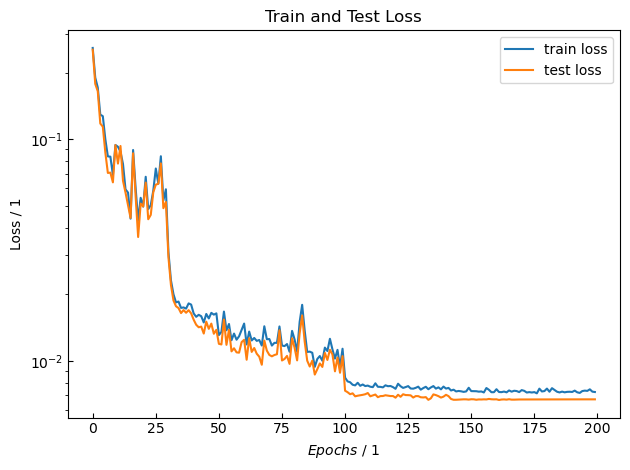

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Speichern Trainingskurve

In [11]:
np.savez('data/models/hyperparams/loss_005_004.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998085884714071 , R^2(NH3) = 0.9995571713296928
Test Dataset: R^2(H2) = 0.9999262985434743 , R^2(NH3) = 0.9997837608780393
Max Error Training: |x_H2 - x_H2,pred| = 0.049431610152056216 , |x_NH3 - x_NH3,pred| = 0.0256242098435481
Max Error Test: |x_H2 - x_H2,pred| = 0.007953865802653892 , |x_NH3 - x_NH3,pred| = 0.011125102785954369


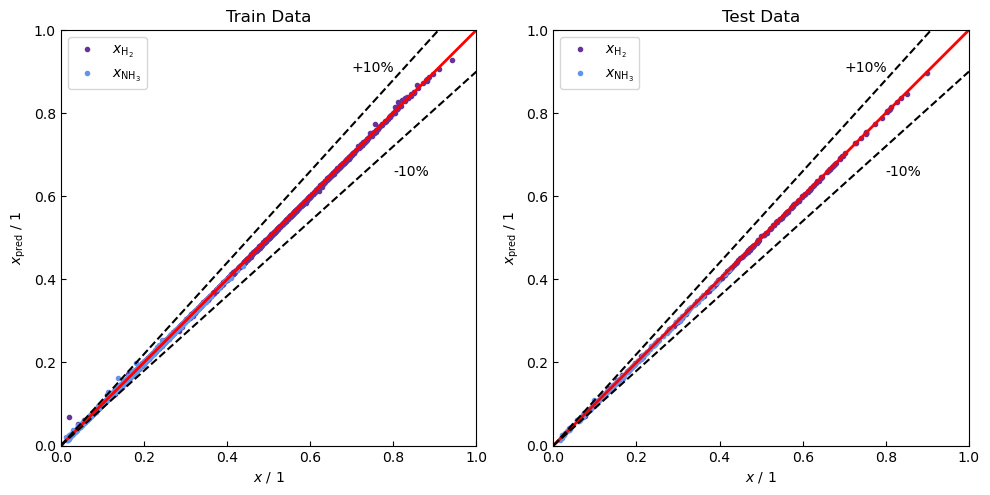

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

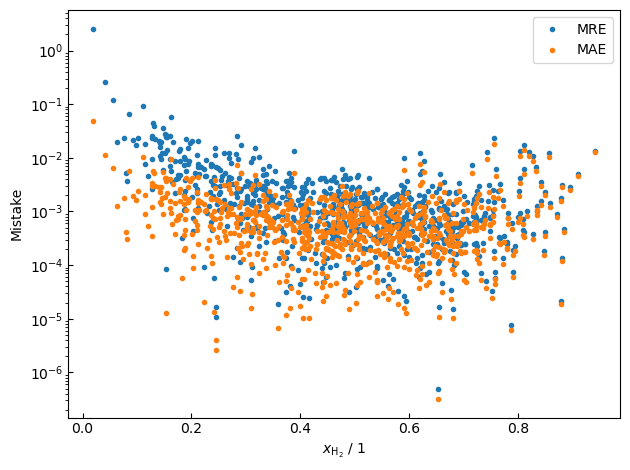

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

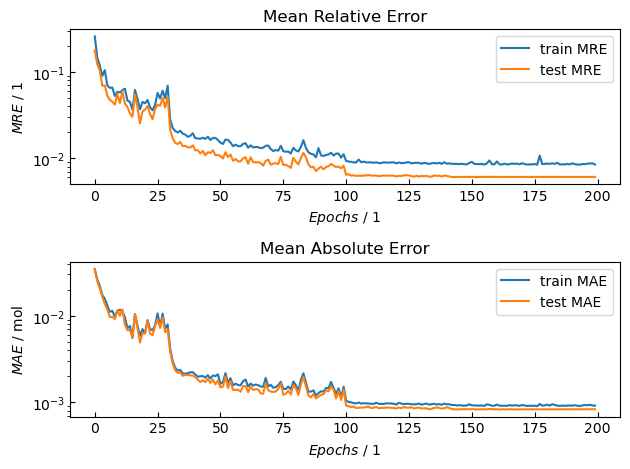

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

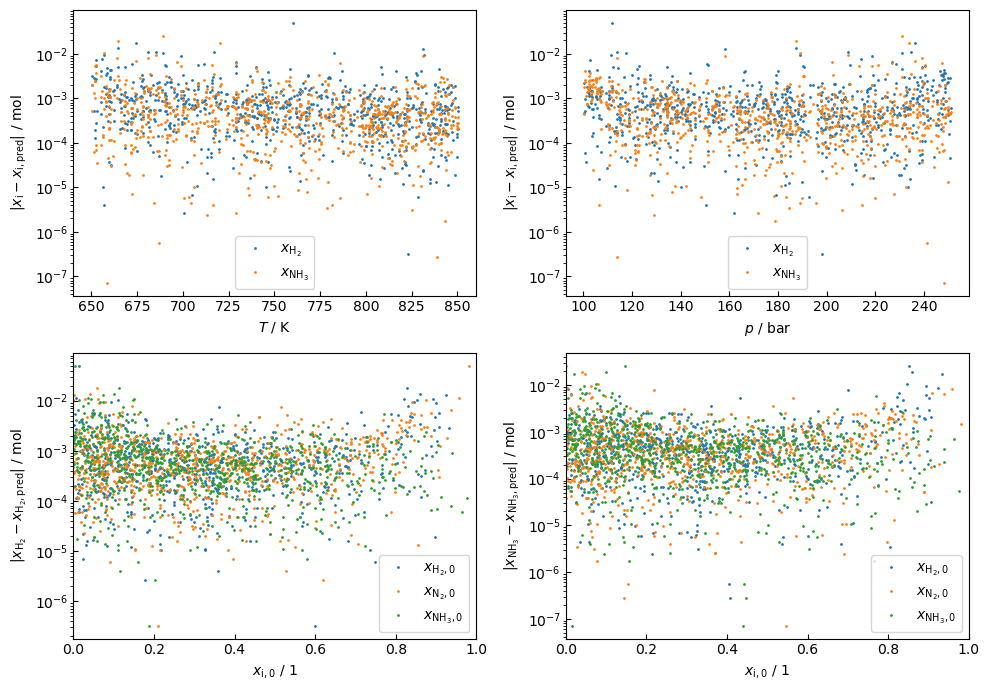

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

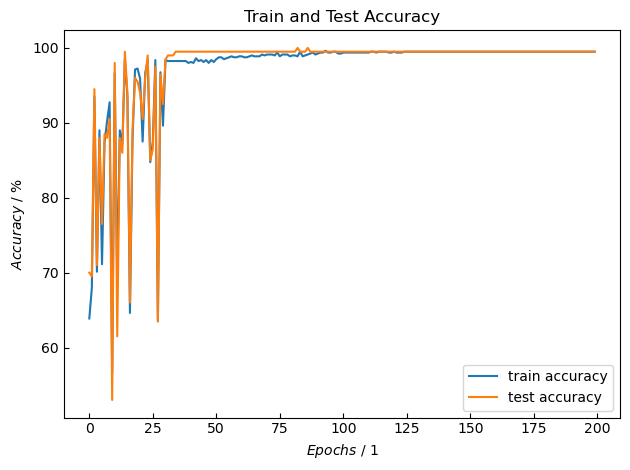

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.3154e+00, -1.2227e+00,  5.9243e-01, -1.0401e+00,  4.8162e-01],
        [ 2.8346e-01, -1.2069e+00,  2.1403e-03, -2.5448e-01,  2.5799e-01],
        [ 3.9241e-01, -1.5774e+00,  1.3533e-01, -6.1199e-01,  4.9269e-01],
        [-2.1849e-01,  1.3309e-01, -1.0097e-02,  1.1138e+00, -1.1284e+00],
        [ 4.5679e-01,  9.5400e-01, -1.0174e+00,  5.9541e-02,  9.3759e-01],
        [-6.8468e-02, -1.0068e+00, -8.0976e-01, -5.4473e-01,  1.3514e+00],
        [-3.4418e-01,  2.9310e-01, -5.0316e-01,  1.9839e-01,  2.9102e-01],
        [ 1.5115e+00, -6.7851e-01, -6.9327e-01, -1.1582e+00,  1.8642e+00],
        [ 9.2303e-01, -1.1778e-01, -1.1215e+00,  9.6405e-01,  1.1525e-01],
        [-7.6136e-01, -8.1228e-01, -5.8263e-01, -6.4795e-01,  1.2340e+00],
        [ 9.1161e-01, -3.6683e-01,  6.0314e-02, -1.8765e-01,  1.3260e-01],
        [ 8.7219e-01, -1.1286e+00, -9.8994e-01, -3.3050e-01,  1.3093e+00],
        [-4.4606e-01, -1.2031e+00, -1.4157e+00,  2.1154e+00, -7.7283e-01],
        [ 3.7597e-01,  1.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.2833,  0.1275, -0.1768, -0.2591,  0.2786],
         [ 0.0426, -0.1996, -0.1425, -0.3728,  0.2286],
         [-0.0066,  0.1474,  0.3236, -0.1915, -0.0409],
         [-0.0830,  0.2421, -0.3612,  0.2203, -0.1870],
         [ 0.2240, -0.2866,  0.3481, -0.4402,  0.2888],
         [ 0.1381, -0.0937,  0.1163,  0.3071, -0.2165],
         [ 0.2899, -0.0720, -0.5117, -0.1595, -0.4016],
         [ 0.0731,  0.0173,  0.2558, -0.1526,  0.1792],
         [ 0.1512,  0.0439, -0.1144,  0.4701,  0.2016],
         [ 0.2693,  0.2040,  0.1471, -0.3824, -0.0357],
         [-0.0880, -0.0499, -0.0594, -0.3387, -0.3697],
         [ 0.1801, -0.0248,  0.2857, -0.3124,  0.3392],
         [-0.1485, -0.0631, -0.0435, -0.1269, -0.2587],
         [-0.0654,  0.1694,  0.4197, -0.0621,  0.1243],
         [-0.3755,  0.1157, -0.1534,  0.0826, -0.0046],
         [-0.0014,  0.0429, -0.3886,  0.1473, -0.2623],
         [-0.1544,  0.0325, -0.1173,  0.1861, -0.2447],
         [-0.2563,  0.113

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.9818, 0.0714, 0.9613, 0.3174, 0.3533],
        [0.1182, 0.0166, 0.1234, 0.1076, 0.2905]])
tensor([[ 0.5603, -0.3616],
        [ 0.0880,  0.1123]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.4542,  1.6025, -0.4418,  1.6929, -1.2966],
        [-1.0850,  1.4037,  0.1139,  1.0708, -1.2062],
        [-0.0936, -0.7574, -0.8123,  1.4908, -0.7265],
        [-0.8378, -1.4711, -1.1141, -0.9800,  2.0950],
        [-1.4110, -0.2312, -0.6587,  0.4828,  0.1530],
        [-1.4867, -0.1183,  0.8673,  0.1865, -1.0418],
        [ 0.9036, -1.1231,  0.0584,  0.4135, -0.4800],
        [-0.7306, -1.6883,  0.7132, -1.0389,  0.3619],
        [ 0.9047, -0.9357, -1.0592,  2.1913, -1.2002],
        [ 1.4930, -0.5700, -0.4010,  0.0345,  0.3583],
        [ 1.0014,  1.1074,  0.5264,  0.4693, -0.9962],
        [ 1.1297, -0.9092, -0.3552, -0.4903,  0.8496],
        [ 0.5486,  0.5164, -0.8233,  1.3074, -0.5283],
        [ 0.3140,  0.9699, -1.0414, -0.7660,  1.8049],
        [ 1.4349,  0.6872, -0.6319,  1.9327, -1.3553],
        [-1.3888, -0.1891,  1.3511, -0.3222, -0.9966],
        [-0.0121, -0.9362, -0.4409,  1.5594, -1.1612],
        [-0.9268, -0.3086, -0.6741,  1.1812, -0.5457],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()